# **Paper Information**

The paper that was implemented is "Diff-Retinex: Rethinking Low-light Image Enhancement with A Generative
Diffusion Model".

Paper Authors: Xunpeng Yi, Han Xu, Hao Zhang, Linfeng Tang, Jiayi Ma

It could be found at: https://arxiv.org/pdf/2308.13164

Code Authors: Hamza Etçibaşı, Enes Şanlı

Contact Information: hamza.etcibasi@metu.edu.tr, sanli.enes@metu.edu.tr

# **Paper Summary**

Diff-Retinex is a physically explainable and generative diffusion model for low-light image enhancement. It rethinks the low-light image enhancement task by integrating the advantages of the physical model and the generative network. The Retinex model decomposes the image into illumination and reflectance images, and the generative diffusion model enhances the illumination image while preserving the reflectance image. This results in enhanced images that are both brighter and more realistic.

Diff-Retinex is shown to be effective on a variety of real-world low-light datasets, and it outperforms state-of-the-art methods both qualitatively and quantitatively. It is also shown to be generalizable to a variety of low-light conditions.

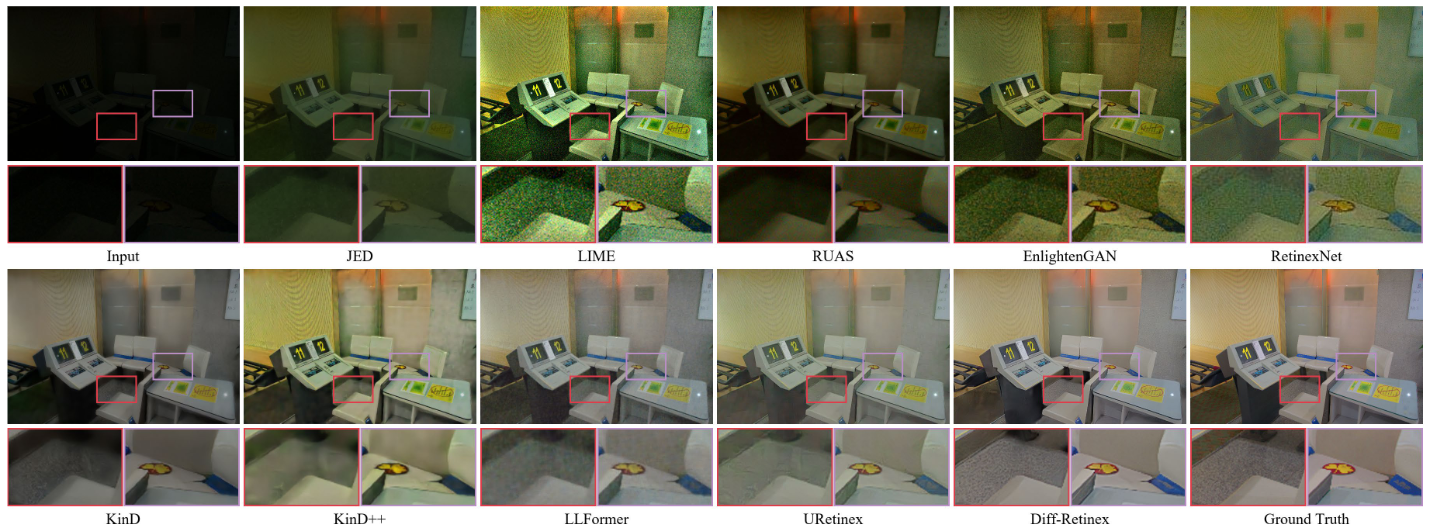

# **Process**

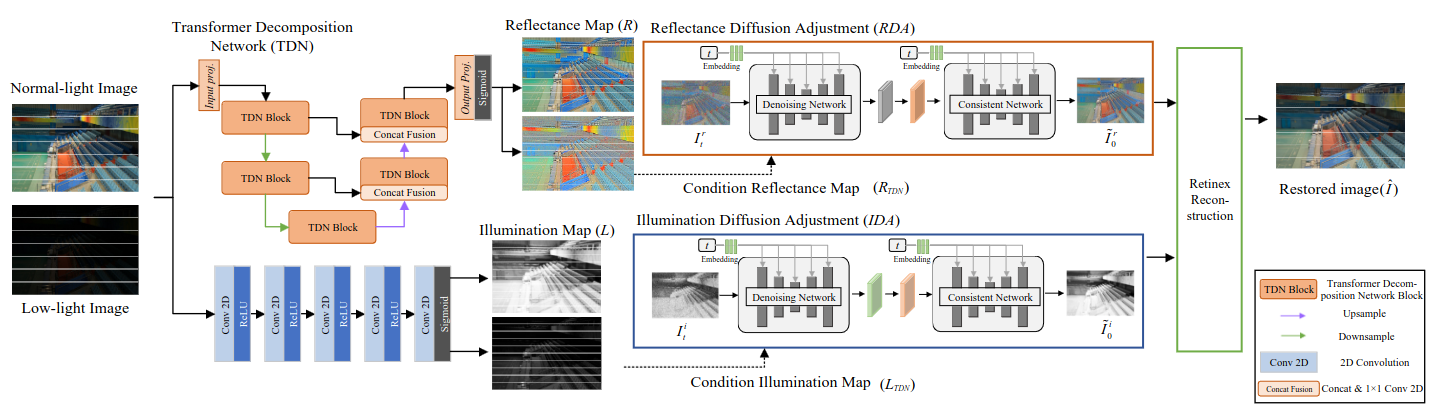

Diff-Retinex has 2 different stage. The first stage tries to decompose each image into illimunation images and reflectance images. This called as TDN Network. The second stage is a Conditional Diffusion model (SR3), in this stage model enhances the illumination image while preserving the reflectance image.


**TDN Network**

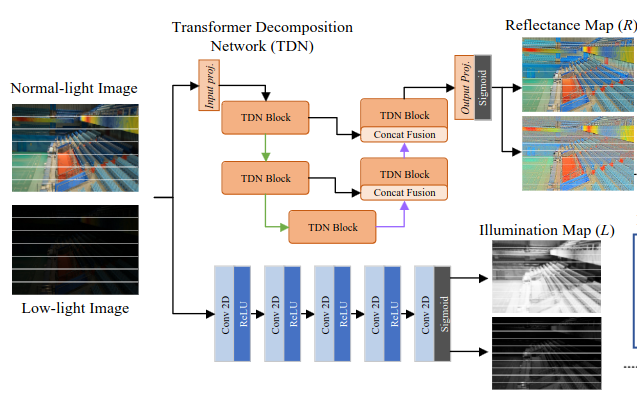

In paper, authors create a TDN network. Tansformer decomposition network (TDN) consists of two branches, the reflectance decomposition branch and the illumination decomposition branch. 
In the illumination decomposition branch, it makes up of several convolutional layers to reduce the amount of calculation on the premise of ensuring the decomposition effect.
In the reflectance decomposition branch is composed of a multi-stage Transformer encoder and decoder. Considering the high attention computing overhead in Transformer, they design a novel multi-head depth-wise convolutions layer attention (MDLA) for computing attention form in TDN.
With **Reflectance Consistency Loss**, **Reconstruction Loss** and **Illumination Smoothness Loss** these network can learn decompose each image into illimunation and reflectance images.

**Reflectance Consistency Loss:** Considering that the reflectance of objects is invariant in various lighting conditions, they constrain the consistency of reflectance maps in different lighting conditions. Specifically, It can be described as:

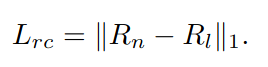


**Reconstruction Loss:** It guarantees that the decomposed Reflectance and Illumination images can reconstruct the original image.

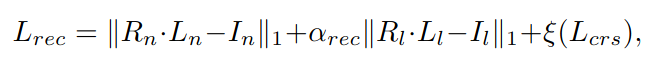

ξ(Lcrs) is an small auxiliary function for the cross multiplication of the illumination and reflection maps for low and normal light.

**Illumination Smoothness Loss:** Considering the illumination should be piece-wise smooth, they constrain it by:

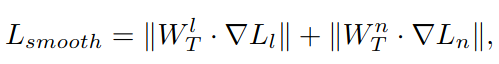

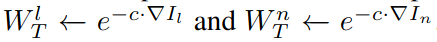

**TOTAL LOSS:** Ultimately, the overall decomposition loss is denoted as:

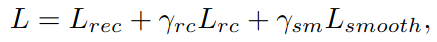

**Conditional Diffusion Network**

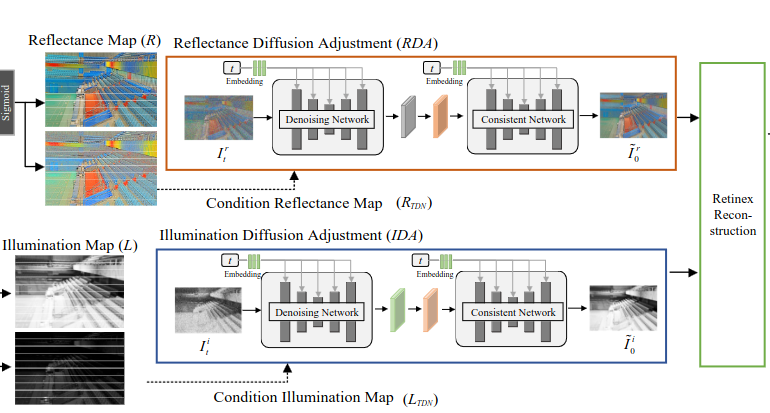

This stage refines the illumination and reflectance components separately. The paper employs a single diffusion network architecture with different weights for each refinement task. The network, based on the SR3 (Image Super-Resolution via Iterative Refinement) paper, operates in a conditional manner. It takes the low-light illumination or reflectance map from the TDN network as input and progressively enhances it.

**Reconstruction**

Finally, the enhanced illumination and reflectance maps are combined using a dot product to generate the final high-quality image.

**Qualitive Results**

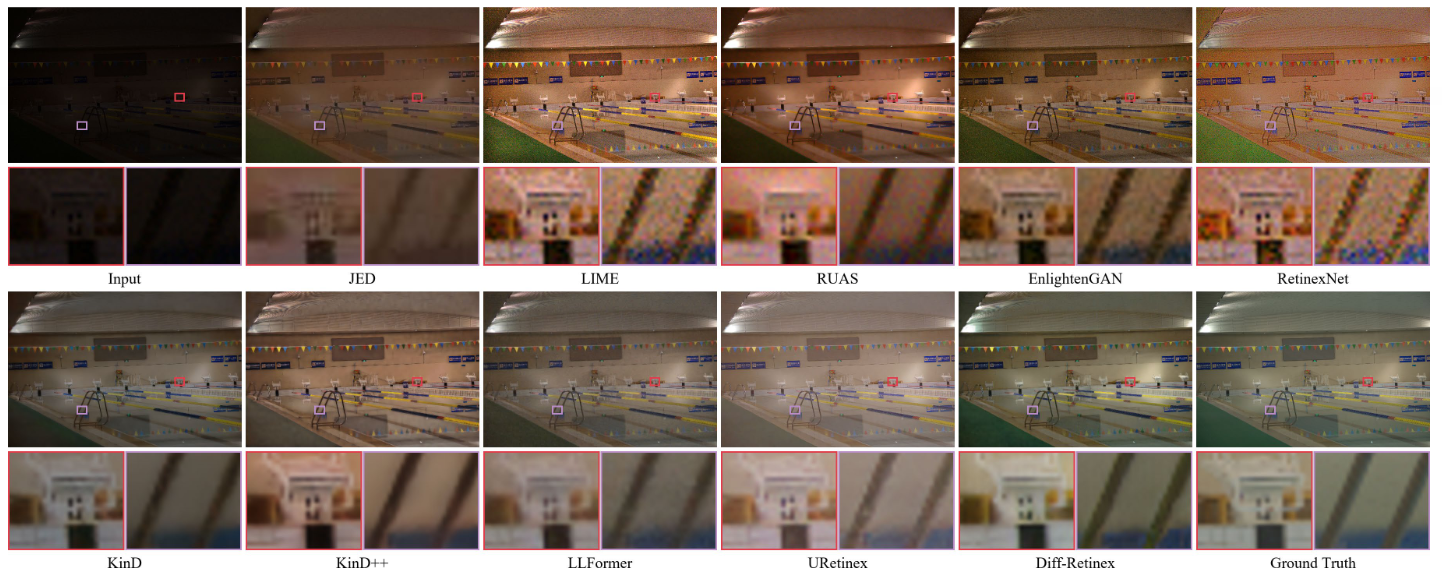

**Quantitive Results**

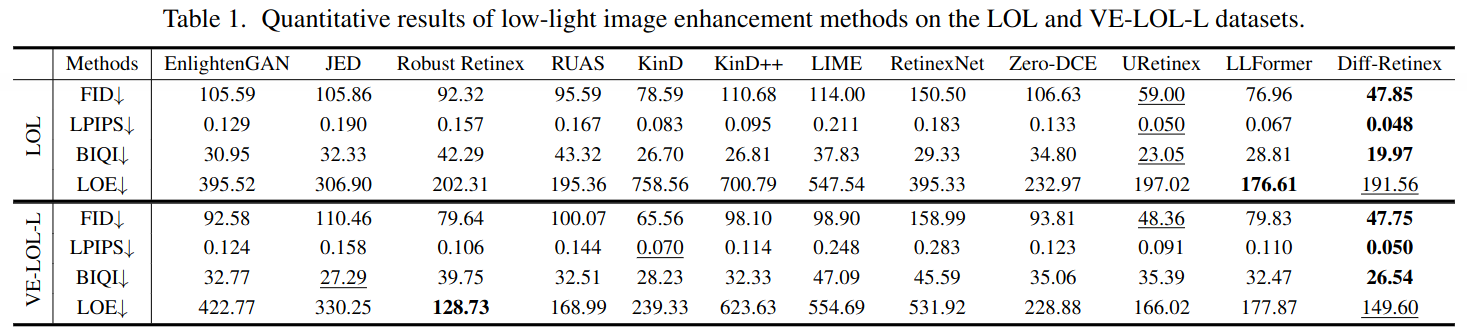


# Import the Libraries

In [ ]:
# !chmod +x download_data.sh
# !./download_data.sh
# !pip install torchshow
# !mkdir lol_dataset_prosessed
# !mkdir lol_dataset_prosessed/high
# !mkdir lol_dataset_prosessed/highi
# !mkdir lol_dataset_prosessed/highr
# !mkdir lol_dataset_prosessed/low
# !mkdir lol_dataset_prosessed/lowi
# !mkdir lol_dataset_prosessed/lowr
# !mkdir lol_dataset_prosessed_eval
# !mkdir lol_dataset_prosessed_eval/high
# !mkdir lol_dataset_prosessed_eval/highi
# !mkdir lol_dataset_prosessed_eval/highr
# !mkdir lol_dataset_prosessed_eval/low
# !mkdir lol_dataset_prosessed_eval/lowi
# !mkdir lol_dataset_prosessed_eval/lowr
# !pip install einops

### These are for Colab

In [6]:
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import os, cv2
from torch.utils.data import Dataset, DataLoader
from pdb import set_trace as stx
import numbers
import matplotlib.pyplot as plt
from einops import rearrange
from PIL import Image
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torch.nn.init as init
from datasetLoaderLol import check_images
from datasetLoaderLol import LOL_Dataset
from datasetLoaderLol import SRDataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ModelTDN import TDN as TDN
import math

import zipfile
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from math import log
from time import time
from diffusionModel import DiffusionModel
from PIL import Image
import os
from prepare import prepare
import os
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
import os
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from scipy.linalg import sqrtm
import torch
import time
import torchshow
import os



# Hyperparameters

In [7]:
SHUFFLE = False
BATCH_SIZE = 3
EPOCHS = 15
GamaRC = 0.1
GamaSM = 0.1
GamaCT = 1
AlphaRec = 0.3
lr = 0.0001


# Select Device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets


In [9]:
DATASET_TRAIN_HIGH_PATH = './lol_dataset/our485/high'
DATASET_TRAIN_LOW_PATH = './lol_dataset/our485/low'
dataset_train_high = LOL_Dataset(DATASET_TRAIN_HIGH_PATH)
dataset_train_low = LOL_Dataset(DATASET_TRAIN_LOW_PATH)
data_loader_train_high = DataLoader(dataset_train_high, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
data_loader_train_low = DataLoader(dataset_train_low, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Loss for TDN

In [10]:
def total_loss(image_batch_low, image_batch_high,predict_low, predict_high, predict_low_ill, predict_high_ill,c):
    return GamaRC*ReflectanceConsistencyLoss(predict_low, predict_high) + RecunstructionLoss(image_batch_low, image_batch_high , predict_low, predict_high, predict_low_ill, predict_high_ill)
    + GamaSM*IlluminationSmoothnessLoss(image_batch_low, image_batch_high, predict_low_ill, predict_high_ill,c)

def ReflectanceConsistencyLoss(predict_low, predict_high):
    return torch.norm(predict_high - predict_low, p=1)

def RecunstructionLoss(image_batch_low, image_batch_high , predict_low, predict_high, predict_low_ill, predict_high_ill):
    return torch.norm(predict_high.to(device)*predict_high_ill - image_batch_high.to(device), p=1) + AlphaRec * torch.norm(predict_low.to(device)*predict_low_ill - image_batch_low.to(device),p=1)

def IlluminationSmoothnessLoss(image_batch_low, image_batch_high, predict_low, predict_high,c):
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).view(1, 1, 3, 3)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3)


    grayscale_images_low = torch.mean(image_batch_low, dim=1, keepdim=True) #[0]
    grayscale_images_low = torch.sigmoid(grayscale_images_low);
    grad_x_low = F.conv2d(grayscale_images_low, sobel_x, padding=1)
    grad_y_low = F.conv2d(grayscale_images_low, sobel_y, padding=1)
    grad_magnitude_low = torch.sqrt(grad_x_low**2 + grad_y_low**2)
    W_l = torch.exp(-c*grad_magnitude_low).to(device)


    grayscale_images_high = torch.mean(image_batch_high, dim=1, keepdim=True) #[0]
    grayscale_images_high = torch.sigmoid(grayscale_images_high);

    grad_x_high = F.conv2d(grayscale_images_high, sobel_x, padding=1)
    grad_y_high = F.conv2d(grayscale_images_high, sobel_y, padding=1)
    grad_magnitude_high = torch.sqrt(grad_x_high**2 + grad_y_high**2)
    W_h = torch.exp(-c*grad_magnitude_high).to(device)

    sobel_x = sobel_x.cuda()
    sobel_y = sobel_y.cuda()
    #grayscale_predict_low = torch.mean(predict_low, dim=1, keepdim=True) #[0]
    grad_x_low_predict = F.conv2d((predict_low), sobel_x, padding=1)
    grad_y_low_predict = F.conv2d((predict_low), sobel_y, padding=1)
    L_l = torch.sqrt(grad_x_low_predict**2 + grad_y_low_predict**2+ 1e-8)


    #grayscale_images_high = torch.mean(image_batch_high, dim=1, keepdim=True) #[0]
    grad_x_high_predict = F.conv2d((predict_high), sobel_x, padding=1)
    grad_y_high_predict = F.conv2d((predict_high), sobel_y, padding=1)
    L_h = torch.sqrt(grad_x_high_predict**2 + grad_y_high_predict**2 + 1e-8)


    return torch.norm( (W_l * L_l)) + torch.norm((W_h * L_h))




# Training TDN

In [ ]:
model = TDN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, ((data_low), (data_high)) in enumerate(zip(data_loader_train_low, data_loader_train_high)):
        optimizer.zero_grad()
        outputs_lowR,outputs_low = model(data_low.to(device))
        outputs_highR, outputs_high = model(data_high.to(device))
        loss = total_loss( data_low, data_high,outputs_lowR,outputs_highR,outputs_low,outputs_high,10)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        single_image = outputs_high[0]
        if i % 15 == 14:  # Her 100 mini-batch'de bir kaybı yazdır
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0

print('Training finished')

# Save Model


In [ ]:
model_path = 'TDN.pth'
torch.save(model.state_dict(),model_path)

# Inference TDN

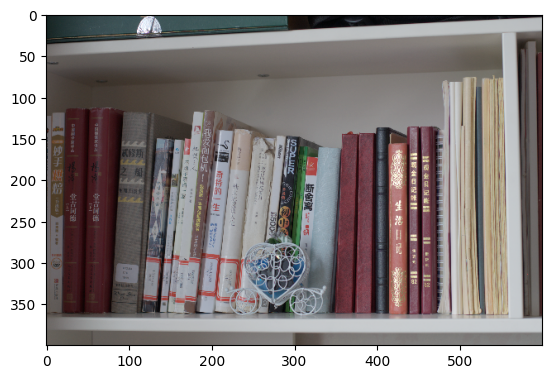

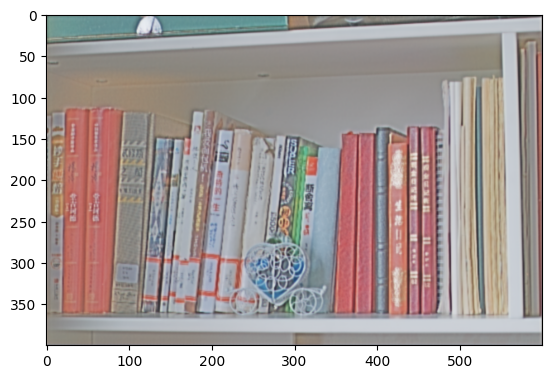

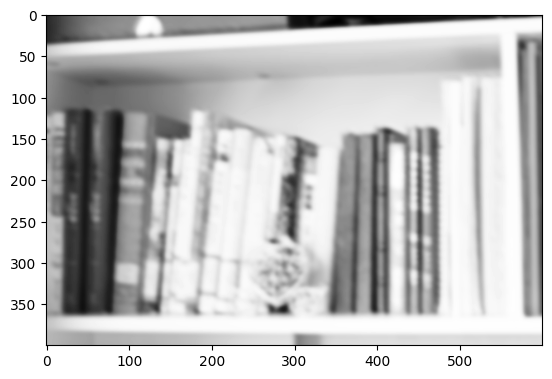

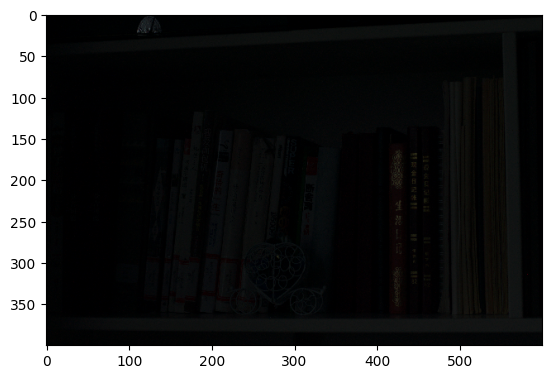

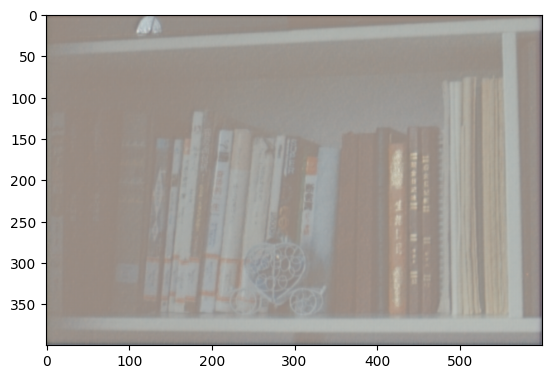

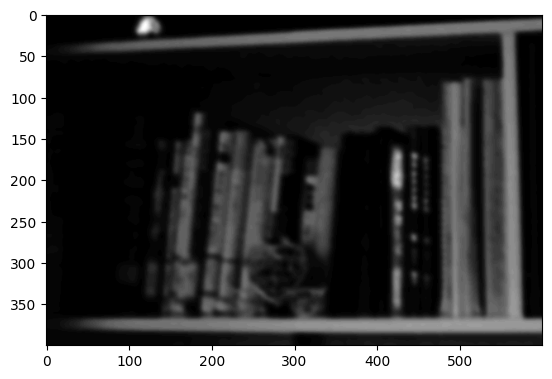

In [11]:
model = TDN().to(device)
model.load_state_dict(torch.load("TDN.pth"))

##### Prepare dataloader for inference, make batch size 1 ###########################
data_loader_train_high = DataLoader(dataset_train_high, batch_size=1, shuffle=SHUFFLE)
data_loader_train_low  = DataLoader(dataset_train_low, batch_size=1, shuffle=SHUFFLE)
#####################################################################################
with torch.no_grad():
  number_image=0
  for i in data_loader_train_high:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()

      save_path = './lol_dataset_prosessed/high/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/highr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image,cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed/highi/'+str(number_image)+'.png'
      image.save(save_path)

with torch.no_grad():
  number_image=0
  for i in data_loader_train_low:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/low/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed/lowr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image, cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed/lowi/'+str(number_image)+'.png'
      image.save(save_path)
prepare(sizem = (160, 160), train="train")

# Hyperparameters for Diffusion Model

In [12]:
timestep = 1000
BATCH = 32
lr_img = 0.0001
epochs = 10000


# Sampling Function for Diffusion Model

In [13]:

def sample(typem,model,train, lr_img, epoch, device="cuda"):

    model.to(device)
    model.eval()

    with torch.no_grad():
        y = torch.randn_like(lr_img, device=device)

        lr_img = lr_img.to(device)
        for i, t in enumerate(range(model.time_steps - 1, 0, -1)):
            alpha_t, alpha_t_hat, beta_t = model.alphas[t], model.alpha_hats[t], model.betas[t]

            t = torch.tensor(t, device=device).long()
            pred_noise = model(torch.cat([lr_img, y], dim=1), alpha_t_hat.view(-1).to(device))
            y = (torch.sqrt(1 / alpha_t)) * (y - (1 - alpha_t) / torch.sqrt(1 - alpha_t_hat) * pred_noise)
            if t > 1:
                noise = torch.randn_like(y)
                y = y + torch.sqrt(beta_t) * noise

    # Define the folder name
    if train == "train" and typem == "ill":
      folder_name = "sr3_samples_ill"
    if train == "train" and typem == "ref":
      folder_name = "sr3_samples_ref"
    if train == "eval" and typem == "ill":
      folder_name = "sr3_samples_eval_ill"
    if train == "eval" and typem == "ref":
      folder_name = "sr3_samples_eval_ref"


    # Check if the folder exists, if not, create it
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    tensor = y[0].detach().cpu()
    tensor = tensor.clamp(0, 1) * 255
    tensor = tensor.byte()
    tensor = tensor.permute(1, 2, 0)  # C x H x W -> H x W x C

    np_array = tensor.numpy()

    image = Image.fromarray(np_array)

    image.save( os.path.join(folder_name, f"{epoch}.png"))

def take_sample_and_save_illumination(epoch, train):

    ds_ = SRDataset("./dataset/lowIllumination","./dataset/highIllumination")
    loader_ = DataLoader(ds_, batch_size=1, shuffle=False)

    # Get the first batch of data
    x, y = next(iter(loader_))
    x = x.to(device)

    sample("ill", ddpm, train, x, epoch=epoch, device=device)
def take_sample_and_save_reflectance(epoch, train):

    ds_ = SRDataset("./dataset/lowReflectance","./dataset/highReflectance")
    loader_ = DataLoader(ds_, batch_size=1, shuffle=False)

    # Get the first batch of data
    x, y = next(iter(loader_))
    x = x.to(device)

    sample("ref", ddpm, train, x, epoch=epoch, device=device)
def eval_and_save_illumination(epoch=0, train="eval"):

    ds_ = SRDataset("./eval/lowIllumination","./eval/highIllumination")
    loader_ = DataLoader(ds_, batch_size=1, shuffle=False)

    for i, (x, y) in enumerate(loader_):
        sample("ill", ddpm, train,x, epoch=i, device=device)
def eval_and_save_reflectance(epoch=0, train="eval"):

    ds_ = SRDataset("./eval/lowReflectance","./eval/highReflectance")
    loader_ = DataLoader(ds_, batch_size=1, shuffle=False)

    for i, (x, y) in enumerate(loader_):
        sample("ref", ddpm, train,x, epoch=i, device=device)



# Train and Save Diffusion Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm = DiffusionModel(timestep).to(device)

ddpm.load_state_dict(torch.load("illumination.pt"))
ds = SRDataset("./dataset/lowIllumination","./dataset/highIllumination")
loader = DataLoader(ds, batch_size=BATCH, shuffle=False)

opt = torch.optim.Adam(ddpm.model.parameters(), lr=lr_img)
criterion = nn.MSELoss(reduction="mean")

ddpm.model.to(device)
for ep in range(epochs):
    ddpm.model.train()
    # print(f"Epoch {ep}:")
    losses = []
    stime = time.time()

    for i, (x, y) in enumerate(loader):

        bs = y.shape[0]
        x, y = x.to(device), y.to(device)
        ts = torch.randint(low=1, high=ddpm.time_steps, size=(bs,))
        gamma = ddpm.alpha_hats[ts].to(device)
        ts = ts.to(device=device)

        y, target_noise = ddpm.add_noise(y, ts)
        y = torch.cat([x, y], dim=1)

        predicted_noise = ddpm.model(y, gamma)
        loss = criterion(target_noise, predicted_noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    ftime = time.time()
    print(f"Epoch {ep} trained in {(ftime - stime)}s; Avg loss => {sum(losses)/len(losses)+1}")
    if ep % 50 == 0 and ep != 0:
        take_sample_and_save_illumination(train = "train" ,epoch=ep)
    if ep % 100 == 0 and ep != 0:
        # Define the folder name
        folder_name = "sr3_models"

        # Check if the folder exists, if not, create it
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        torch.save(ddpm.state_dict(), f"sr3_illumination_{ep}.pt")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm = DiffusionModel(timestep).to(device)

ddpm.load_state_dict(torch.load("reflectance.pt"))
ds = SRDataset("./dataset/lowReflectance","./dataset/highReflectance")
loader = DataLoader(ds, batch_size=BATCH, shuffle=False)

opt = torch.optim.Adam(ddpm.model.parameters(), lr=lr_img)
criterion = nn.MSELoss(reduction="mean")

ddpm.model.to(device)
for ep in range(epochs):
    ddpm.model.train()
    # print(f"Epoch {ep}:")
    losses = []
    stime = time.time()

    for i, (x, y) in enumerate(loader):

        bs = y.shape[0]
        x, y = x.to(device), y.to(device)
        ts = torch.randint(low=1, high=ddpm.time_steps, size=(bs,))
        gamma = ddpm.alpha_hats[ts].to(device)
        ts = ts.to(device=device)

        y, target_noise = ddpm.add_noise(y, ts)
        y = torch.cat([x, y], dim=1)

        predicted_noise = ddpm.model(y, gamma)
        loss = criterion(target_noise, predicted_noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    ftime = time.time()
    print(f"Epoch {ep} trained in {(ftime - stime)}s; Avg loss => {sum(losses)/len(losses)+1}")
    if ep % 50 == 0 and ep != 0:
        take_sample_and_save_reflectance(train = "train" ,epoch=ep)
    if ep % 100 == 0 and ep != 0:
        # Define the folder name
        folder_name = "sr3_models"

        # Check if the folder exists, if not, create it
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        torch.save(ddpm.state_dict(), f"sr3_reflectance_{ep}.pt")


# Eval TDN

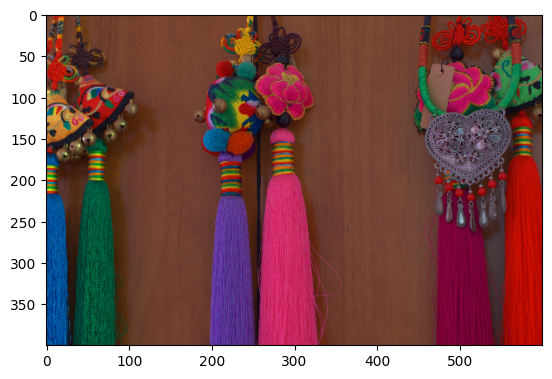

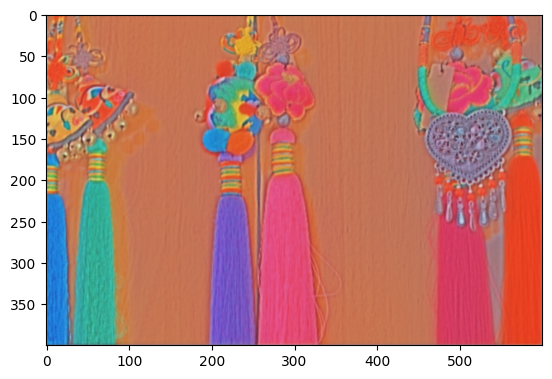

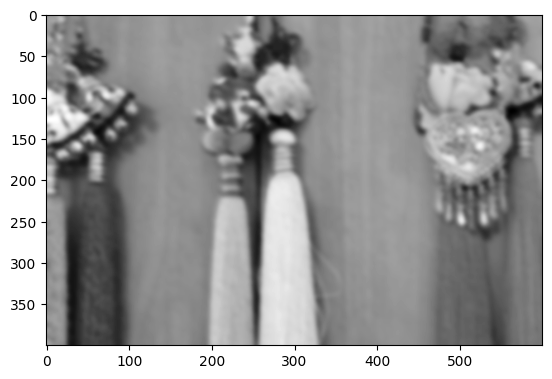

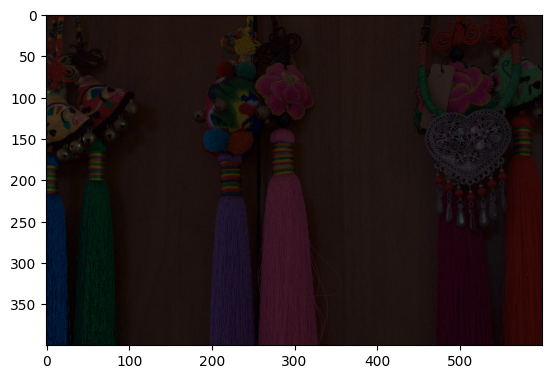

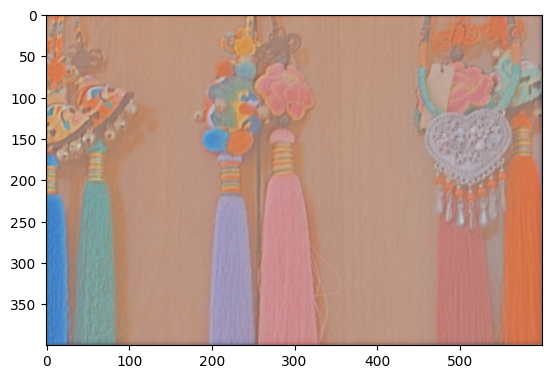

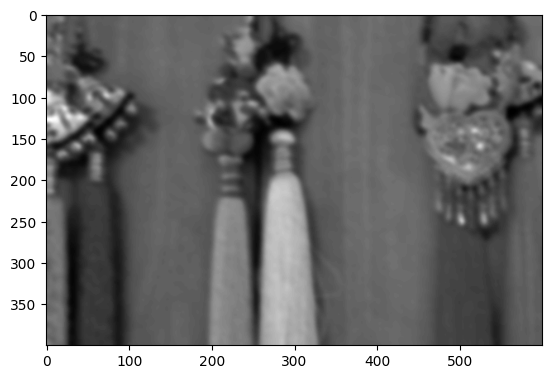

In [14]:
model = TDN().to(device)
model.load_state_dict(torch.load("TDN.pth"))

DATASET_EVAL_HIGH_PATH = './lol_dataset/eval15/high'
DATASET_EVAL_LOW_PATH = './lol_dataset/eval15/low'
dataset_eval_high = LOL_Dataset(DATASET_EVAL_HIGH_PATH)
dataset_eval_low = LOL_Dataset(DATASET_EVAL_LOW_PATH)

##### Prepare dataloader for inference, make batch size 1 ###########################
data_loader_eval_high = DataLoader(dataset_eval_high, batch_size=1, shuffle=SHUFFLE)
data_loader_eval_low  = DataLoader(dataset_eval_low, batch_size=1, shuffle=SHUFFLE)
#####################################################################################
with torch.no_grad():
  number_image=0
  for i in data_loader_eval_high:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()

      save_path = './lol_dataset_prosessed_eval/high/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed_eval/highr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image,cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed_eval/highi/'+str(number_image)+'.png'
      image.save(save_path)

with torch.no_grad():
  number_image=0
  for i in data_loader_eval_low:
      number_image += 1
      single_image = i[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed_eval/low/'+str(number_image)+'.png'
      image.save(save_path)

      output_batch,other_batch = model(i.to(device))

      single_image = output_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image)
        plt.show()
      save_path = './lol_dataset_prosessed_eval/lowr/'+str(number_image)+'.png'
      image.save(save_path)


      single_image = other_batch[0]
      tensor = (single_image * 255).byte()  # Scale to 0-255 and convert to byte tensor
      image = transforms.ToPILImage()(tensor)
      if(number_image==1):
        plt.imshow(image, cmap='gray')
        plt.show()
      save_path = './lol_dataset_prosessed_eval/lowi/'+str(number_image)+'.png'
      image.save(save_path)
prepare(sizem = (160, 160), train="eval")

In [15]:
ddpm = DiffusionModel(1000).to(device)
ddpm.load_state_dict(torch.load("illumination.pt"))
eval_and_save_illumination()

In [16]:
ddpm = DiffusionModel(1000).to(device)
ddpm.load_state_dict(torch.load("reflectance.pt"))
eval_and_save_reflectance()

In [26]:
import os
import cv2
import numpy as np

# Directories containing the images
reflectance_dir = './sr3_samples_eval_ref'
illumination_dir = './sr3_samples_eval_ill'
output_dir = './reconstructed'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Number of images
num_images = 15

# Process each pair of images
for i in range(0, num_images):
    # File paths
    reflectance_path = os.path.join(reflectance_dir, f'{i}.png')
    illumination_path = os.path.join(illumination_dir, f'{i}.png')

    # Read images
    reflectance_img = cv2.imread(reflectance_path, cv2.IMREAD_COLOR)
    illumination_img = cv2.imread(illumination_path, cv2.IMREAD_COLOR)

    # Check if images are loaded successfully
    if reflectance_img is None:
        print(f"Error: Unable to read image {reflectance_path}")
        continue
    if illumination_img is None:
        print(f"Error: Unable to read image {illumination_path}")
        continue

    # Convert images to float32 and normalize
    reflectance_img = reflectance_img.astype(np.float32) / 255.0
    illumination_img = illumination_img.astype(np.float32) / 255.0

    # Reconstruct image by multiplying reflectance and illumination
    reconstructed_img = reflectance_img * illumination_img

    # Convert the result back to 8-bit image
    reconstructed_img = (reconstructed_img * 255).astype(np.uint8)
    reconstructed_img = cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB)
    # Save the reconstructed image
    output_path = os.path.join(output_dir, f'{i+1}.png')
    cv2.imwrite(output_path, reconstructed_img)

print("Reconstruction complete. Images saved in 'reconstructed' directory.")

Reconstruction complete. Images saved in 'reconstructed' directory.


# Calculate PSNR Score, SSIM Score and FID Score

In [ ]:

# Directories
high_dir = './lol_dataset_prosessed/high'
reconstructed_dir = './reconstructed'

# Image size
image_size = (160, 160)

# Helper function to load and resize images
def load_and_resize_image(filepath, size):
    img = Image.open(filepath).convert('RGB')
    img = img.resize(size, Image.ANTIALIAS)
    return np.array(img)

# Load and resize images
high_images = []
reconstructed_images = []

for i in range(1, 16):
    high_image_path = os.path.join(high_dir, f'{i}.png')
    reconstructed_image_path = os.path.join(reconstructed_dir, f'{i}.png')

    high_image = load_and_resize_image(high_image_path, image_size)
    reconstructed_image = load_and_resize_image(reconstructed_image_path, image_size)

    high_images.append(high_image)
    reconstructed_images.append(reconstructed_image)

high_images = np.array(high_images)
reconstructed_images = np.array(reconstructed_images)

# Compute PSNR and SSIM
psnr_values = []
ssim_values = []

for i in range(len(high_images)):
    psnr_value = psnr(high_images[i], reconstructed_images[i])
    ssim_value, _ = ssim(high_images[i], reconstructed_images[i], full=True, multichannel=True)

    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

# Compute mean PSNR and SSIM
mean_psnr = np.mean(psnr_values)
mean_ssim = np.mean(ssim_values)

print(f'Mean PSNR: {mean_psnr}')
print(f'Mean SSIM: {mean_ssim}')

# Function to calculate the FID
def calculate_fid(real_images, generated_images):
    # Load InceptionV3 model
    model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Resize images to 299x299
    real_images_resized = tf.image.resize(real_images, (299, 299)).numpy()
    generated_images_resized = tf.image.resize(generated_images, (299, 299)).numpy()

    # Preprocess images for InceptionV3
    real_images_resized = tf.keras.applications.inception_v3.preprocess_input(real_images_resized)
    generated_images_resized = tf.keras.applications.inception_v3.preprocess_input(generated_images_resized)

    # Get the feature representations
    act1 = model.predict(real_images_resized)
    act2 = model.predict(generated_images_resized)


    # Calculate the mean and covariance of the feature representations
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)


    epsilon = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * epsilon
    sigma2 += np.eye(sigma2.shape[0]) * epsilon


    # Check for numerical issues
    if np.any(np.isnan(mu1)) or np.any(np.isnan(mu2)) or np.any(np.isnan(sigma1)) or np.any(np.isnan(sigma2)):
        print("Numerical instability detected. Check your input data.")
        return np.inf

    # Calculate the FID score
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Convert images to float32
high_images = high_images.astype(np.float32)
reconstructed_images = reconstructed_images.astype(np.float32)

# Calculate FID
fid_value = calculate_fid(high_images, reconstructed_images)
print(f'FID: {fid_value}')

### Quantitative Results Comparison

| Metric       | Original Scores | Reproduced|
|--------------|----------------:|-------------------:|
| PSNR         |            21.98|              20.01 |
| SSIM         |            0.863|              0.618 |
| FID          |            47.85|             165.15 |

*Table 1:* Comparison of Original Scores and Reproduced Quantitative Results for Diff-Retinex